# Generate CTIO Spectrum using  PySynPhot
=========================================================================


The purpose is to start to use PySynPhot software to calculate things on
SED, filter transmission,... For Calibration

- Sylvie Dagoret-Campagne
- Affiliation LAL-IN2P3-CNRS
- Work : LSST & StarDice
- date June 16 2017




- Read filters for LSST provided by KG May 30th 2017
- Generate LibRadTran atmosphere for any airmass - H2O - O3 combinations
- Generate the observed spectrum

In [1]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pandas as pd
import os
import re

In [3]:
import astropy.units as u

In [4]:
import sys
sys.path.append('./libradtransim')

In [5]:
from libsimulateTranspCTIOScattAbs import *

In [6]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [7]:
os.environ['PYSYN_CDBS']

'/Users/dagoret-campagnesylvie/MacOsX/External/PySyn_CDBS/grp/hst/cdbs'

In [8]:
import pysynphot as S
from astropy.io import ascii

# Defining CTIO 0.9m telescope

In [9]:
CTIO_COLL_SURF=0.9*(u.m)**2/(u.cm)**2  # LSST collectif surface
WLMIN=3000.
WLMAX=11000.

In [10]:
CTIO_COLL_SURF.decompose()

<Quantity 9000.0>

In [11]:
S.refs.showref()

thermtable: /Users/dagoret-campagnesylvie/MacOsX/External/PySyn_CDBS/grp/hst/cdbs/mtab/tae17277m_tmt.fits
   waveset: Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True
 comptable: /Users/dagoret-campagnesylvie/MacOsX/External/PySyn_CDBS/grp/hst/cdbs/mtab/0ac1951am_tmc.fits
graphtable: /Users/dagoret-campagnesylvie/MacOsX/External/PySyn_CDBS/grp/hst/cdbs/mtab/0bf2050hm_tmg.fits
      area: 45238.93416


In [12]:
S.refs.setref(area=CTIO_COLL_SURF.decompose(), waveset=None)

In [13]:
S.refs.set_default_waveset(minwave=3000, maxwave=11000, num=8000, delta=10, log=False)

In [14]:
S.refs.showref()

thermtable: /Users/dagoret-campagnesylvie/MacOsX/External/PySyn_CDBS/grp/hst/cdbs/mtab/tae17277m_tmt.fits
   waveset: Min: 3000, Max: 11000, Num: None, Delta: 10, Log: False
 comptable: /Users/dagoret-campagnesylvie/MacOsX/External/PySyn_CDBS/grp/hst/cdbs/mtab/0ac1951am_tmc.fits
graphtable: /Users/dagoret-campagnesylvie/MacOsX/External/PySyn_CDBS/grp/hst/cdbs/mtab/0bf2050hm_tmg.fits
      area: 9000.0


In [15]:
plt.ion()
plt.clf()

## Filters and CCD


- will be replaced by Filter used at CTIO

In [16]:
files_idealfilters=['LSSTFiltersKG/fdata/ideal_u.txt','LSSTFiltersKG/fdata/ideal_g.txt','LSSTFiltersKG/fdata/ideal_r.txt','LSSTFiltersKG/fdata/ideal_i.txt','LSSTFiltersKG/fdata/ideal_z.txt','LSSTFiltersKG/fdata/ideal_y4.txt']

In [17]:
file_lsstoptccd='LSSTFiltersKG/fdata/LSST-ThroughputCCD.xlsx'

In [18]:
NBFILES=len(files_idealfilters)

### Read filters

In [19]:
data_u=np.loadtxt(files_idealfilters[0],skiprows=2)
data_g=np.loadtxt(files_idealfilters[1],skiprows=2)
data_r=np.loadtxt(files_idealfilters[2],skiprows=2)
data_i=np.loadtxt(files_idealfilters[3],skiprows=2)
data_z=np.loadtxt(files_idealfilters[4],skiprows=2)
data_y4=np.loadtxt(files_idealfilters[5],skiprows=2)

In [20]:
wl_u=data_u[:,0]
u=data_u[:,1]
#
wl_g=data_g[:,0]
g=data_g[:,1]
#
wl_r=data_r[:,0]
r=data_r[:,1]
#
wl_i=data_i[:,0]
i=data_i[:,1]
#
wl_z=data_z[:,0]
z=data_z[:,1]
#
wl_y4=data_y4[:,0]
y4=data_y4[:,1]

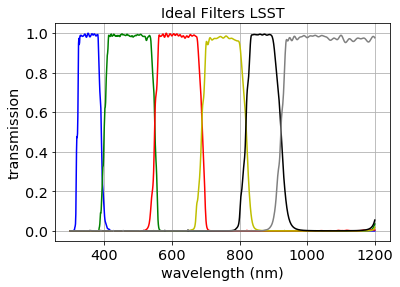

In [21]:
plt.plot(wl_u,u,'b-')
plt.plot(wl_g,g,'g-')
plt.plot(wl_r,r,'r-')
plt.plot(wl_i,i,'y-')
plt.plot(wl_z,z,'k-')
plt.plot(wl_y4,y4,'-',color='grey')
plt.grid()
plt.title("Ideal Filters LSST")
plt.xlabel("wavelength (nm)")
plt.ylabel("transmission")

### Read Throughput et CCD

In [22]:
data_throuthput=pd.read_excel(file_lsstoptccd,skiprow=1)

### Read throughtput and ccd at LSST

In [23]:
wl2=np.array(data_throuthput["WL"])
throughput=np.array(data_throuthput["THROUGHPUT"])
ccdqe=np.array(data_throuthput["CCD2"])
trans_opt_elec=np.array(data_throuthput["THROUGHPUT"]*data_throuthput["CCD2"])

In [24]:
type(wl2)

numpy.ndarray

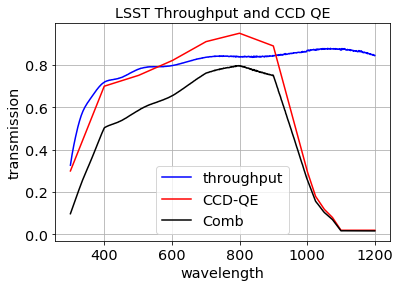

In [25]:
plt.plot(data_throuthput["WL"],data_throuthput["THROUGHPUT"],'b-',label='throughput')
plt.plot(data_throuthput["WL"],data_throuthput["CCD2"],'r-',label='CCD-QE')
plt.plot(data_throuthput["WL"],trans_opt_elec,'k-',label='Comb')
plt.grid()
plt.title("LSST Throughput and CCD QE")
plt.xlabel("wavelength")
plt.ylabel("transmission")
plt.legend()

### Read CTIO QE

- this is the only information avaliable up to now

In [26]:
data_qe = np.loadtxt("./CTIOThroughput/qecurve.txt")  

In [27]:
wl_qe=data_qe[:,0]
tr_qe=data_qe[:,1]/100.

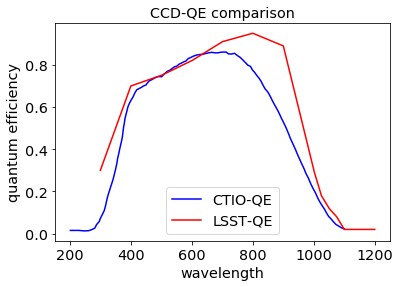

In [28]:
plt.plot(wl_qe,tr_qe,'b-',label='CTIO-QE')
plt.plot(data_throuthput["WL"],data_throuthput["CCD2"],'r-',label='LSST-QE')
plt.legend()
plt.title("CCD-QE comparison")
plt.xlabel("wavelength")
plt.ylabel("quantum efficiency")

## Read atmosphere

### ProcessSimulation(airmass,pwv,ozone,pressure)

- airmass : 1.0, .., 3.0
- pwv in kg/m2  or mm
- ozone in DbU
- Pressure in hPa

In [29]:
path,file=ProcessSimulation(1.,5.,273.,775) 

--------------------------------------------
 2) airmass =  1.0
 2) pwv =  5.0
 3) oz =  273.0
 4) pressure  =  775
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/CT/pp/us/sa/rt/in/RT_CT_pp_us_sa_rt_z10_wv50_oz27.INP')
('Output to file                : ', 'simulations/RT/2.0.1/CT/pp/us/sa/rt/out/RT_CT_pp_us_sa_rt_z10_wv50_oz27.OUT')
('uvspec cmd: ', '/Users/dagoret-campagnesylvie/MacOsX/LSST/softs/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/CT/pp/us/sa/rt/in/RT_CT_pp_us_sa_rt_z10_wv50_oz27.INP > simulations/RT/2.0.1/CT/pp/us/sa/rt/out/RT_CT_pp_us_sa_rt_z10_wv50_oz27.OUT')


In [30]:
fullfilename=os.path.join(path,file)

In [31]:
atm_data=np.loadtxt(fullfilename)

In [32]:
wl_atm=atm_data[:,0]
tr_atm=atm_data[:,1]

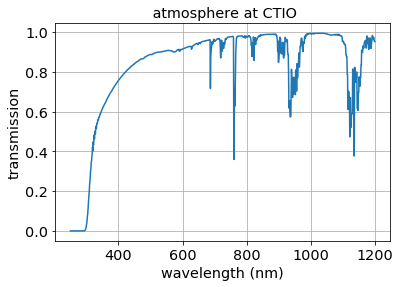

In [33]:
plt.plot(wl_atm,tr_atm)
plt.grid()
plt.title(" atmosphere at CTIO")
plt.xlabel("wavelength (nm)")
plt.ylabel("transmission")
plt.savefig("atm-transm.png")

In [34]:
bp_atm = S.ArrayBandpass(wl_atm*10.,tr_atm, name='CTIO atm')

# Pysynphot

In [35]:
bp_ctio = S.ArrayBandpass(wl_qe*10.,tr_qe, name='CTIO QE')

In [36]:
bp_ctio_atm = bp_ctio*bp_atm


In [37]:
bp_ctio_atm.binning=10.

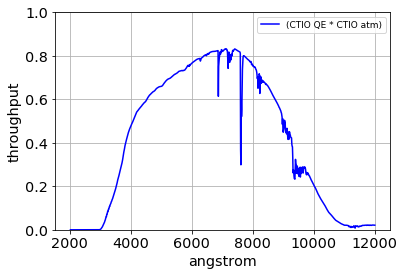

In [38]:
plt.plot(bp_ctio_atm.wave, bp_ctio_atm.throughput, 'b')
plt.grid()
plt.ylim(0, 1.)
plt.xlabel(bp_ctio_atm.waveunits)
plt.ylabel('throughput')
plt.legend([bp_ctio_atm.name], loc=1,fontsize=9)

# Observation

In [39]:
filename = os.path.join(os.environ['PYSYN_CDBS'], 'calspec', 'hd111980_stis_003.fits')
sed = S.FileSpectrum(filename)
sed.flux

array([  2.16790002e-14,   2.66180002e-14,   2.03460007e-14, ...,
         9.32662788e-19,   9.23448099e-19,   9.14324504e-19])

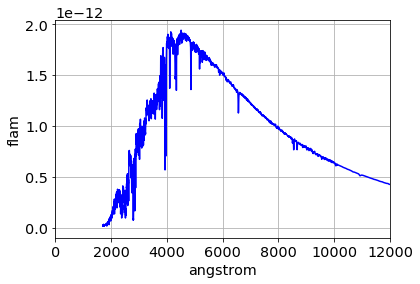

In [40]:
plt.plot(sed.wave,sed.flux,'b-')
plt.grid()
plt.xlim(0.,12000)
plt.xlabel(sed.waveunits)
plt.ylabel(sed.fluxunits)
#plt.title(S.Vega.name)

In [41]:
obs_ctio = S.Observation(sed,bp_ctio_atm)

((CTIO QE * CTIO atm)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


In [42]:
obs_ctio.primary_area=CTIO_COLL_SURF.decompose()

In [43]:
print obs_ctio.primary_area

9000.0


/Users/dagoret-campagnesylvie/MacOsX/External/PySyn_CDBS/grp/hst/cdbs/calspec/hd111980_stis_003.fits * (CTIO QE * CTIO atm)


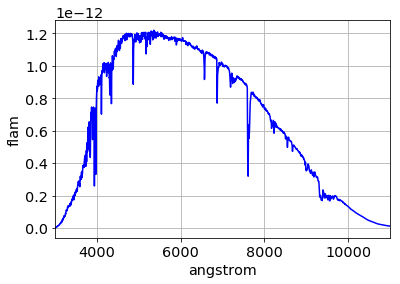

In [44]:
plt.plot(obs_ctio.wave,obs_ctio.flux,'b')
plt.grid()
plt.xlim(WLMIN,WLMAX)
plt.xlabel(obs_ctio.waveunits)
plt.ylabel(obs_ctio.fluxunits)
#plt.title(S.Vega.name)
print obs_ctio.name


/Users/dagoret-campagnesylvie/MacOsX/External/PySyn_CDBS/grp/hst/cdbs/calspec/hd111980_stis_003.fits * (CTIO QE * CTIO atm)


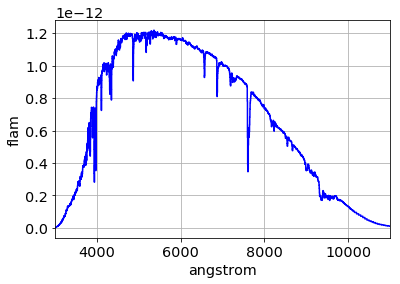

In [45]:
plt.plot(obs_ctio.binwave,obs_ctio.binflux,'b',drawstyle='steps-mid')
plt.xlabel(obs_ctio.waveunits)
plt.ylabel(obs_ctio.fluxunits)
plt.xlim(WLMIN,WLMAX)
#plt.title(sed.name)
print obs_ctio.name
plt.grid()

In [46]:
print obs_ctio.primary_area

9000.0


### Magnitude

In [47]:
print obs_ctio.effstim('obmag') 

-17.9865858159


In [48]:
-2.5*np.log10(obs_ctio.binflux.sum())

22.144962107985428

In [49]:
obs_ctio.convert('counts')

# Reference data

In [50]:
 S.showref()

thermtable: /Users/dagoret-campagnesylvie/MacOsX/External/PySyn_CDBS/grp/hst/cdbs/mtab/tae17277m_tmt.fits
   waveset: Min: 3000, Max: 11000, Num: None, Delta: 10, Log: False
 comptable: /Users/dagoret-campagnesylvie/MacOsX/External/PySyn_CDBS/grp/hst/cdbs/mtab/0ac1951am_tmc.fits
graphtable: /Users/dagoret-campagnesylvie/MacOsX/External/PySyn_CDBS/grp/hst/cdbs/mtab/0bf2050hm_tmg.fits
      area: 9000.0


# Catalog

In [51]:
from astropy.io import fits
filename = os.path.join(os.environ['PYSYN_CDBS'], 'calspec', 'hd111980_stis_003.fits')
with fits.open(filename) as pf:
    print(pf[1].header)

XTENSION= 'BINTABLE'           /Written by IDL:  Wed Dec 24 09:03:03 2014       BITPIX  =                    8 /                                                NAXIS   =                    2 /Binary table                                    NAXIS1  =                   30 /Number of bytes per row                         NAXIS2  =                 3739 /Number of rows                                  PCOUNT  =                    0 /Random parameter count                          GCOUNT  =                    1 /Group count                                     TFIELDS =                    7 /Number of columns                               EXTNAME = 'SCI     '           /                                                EXTVER  =                    1 /                                                INHERIT =                    T /                                                TFORM1  = '1D      '           /Real*8 (double precision)                       TTYPE1  = 'WAVELENGTH'         /Label fo